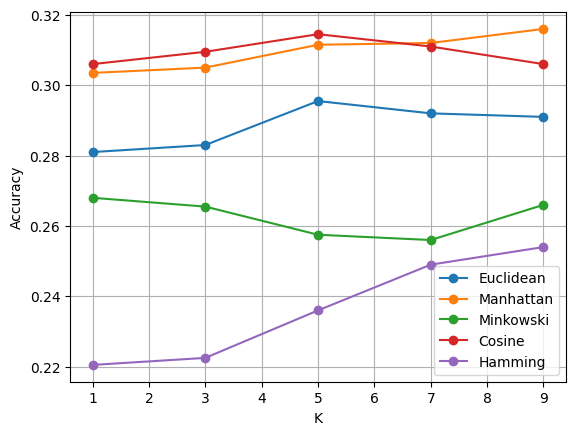

Best Distance Metric: Manhattan
Best K: 9
Accuracy: 0.316
Precision: 0.39821473178047884
Recall: 0.3116886275903004
Confusion Matrix:
 [[ 94.   1.  31.   3.  14.   1.   6.   2.  41.   3.]
 [ 19.  27.  18.   6.  32.   4.  28.   4.  51.   9.]
 [ 32.   0.  76.   5.  47.   8.  16.   4.   7.   0.]
 [ 23.   1.  43.  32.  30.  17.  39.   5.   8.   1.]
 [ 17.   0.  61.   7.  79.   3.  12.   3.  16.   0.]
 [ 18.   1.  42.  15.  40.  25.  28.   4.  10.   2.]
 [  5.   1.  68.   6.  52.   8.  69.   1.   6.   0.]
 [ 12.   3.  40.   3.  53.  10.  11.  40.  16.   5.]
 [ 38.   0.   7.   4.  12.   3.   4.   1. 146.   2.]
 [ 24.   5.  11.  11.  23.   3.  16.  12.  54.  44.]]


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def load_batch(file):
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
    return d[b'data'], np.array(d[b'labels'])

x_train = []
y_train = []

for i in range(1, 6):
    data, labels = load_batch(f"data_batch_{i}")
    x_train.append(data)
    y_train.append(labels)

x_train = np.concatenate(x_train).astype(np.float32) / 255.0
y_train = np.concatenate(y_train)

x_test, y_test = load_batch("test_batch")
x_test = x_test.astype(np.float32) / 255.0
y_test = y_test

train_subset = 10000
test_subset = 2000

x_train = x_train[:train_subset]
y_train = y_train[:train_subset]
x_test = x_test[:test_subset]
y_test = y_test[:test_subset]

def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def minkowski(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

def cosine(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hamming(a, b):
    return np.mean(a != b)

distance_functions = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}

def knn_predict(xtr, ytr, xte, k, dist):
    preds = []
    for x in xte:
        dists = [dist(x, xt) for xt in xtr]
        idx = np.argsort(dists)[:k]
        preds.append(Counter(ytr[idx]).most_common(1)[0][0])
    return np.array(preds)

def confusion_matrix(y_true, y_pred):
    cm = np.zeros((10, 10))
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

def precision_recall(cm):
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    return np.nanmean(precision), np.nanmean(recall)

k_values = [1, 3, 5, 7, 9]
results = {}

for name, func in distance_functions.items():
    accs = []
    for k in k_values:
        preds = knn_predict(x_train, y_train, x_test, k, func)
        accs.append(np.mean(preds == y_test))
    results[name] = accs

for name in results:
    plt.plot(k_values, results[name], marker='o', label=name)

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

best_metric = max(results, key=lambda x: max(results[x]))
best_k = k_values[np.argmax(results[best_metric])]

best_preds = knn_predict(
    x_train, y_train, x_test, best_k, distance_functions[best_metric]
)

cm = confusion_matrix(y_test, best_preds)
precision, recall = precision_recall(cm)

print("Best Distance Metric:", best_metric)
print("Best K:", best_k)
print("Accuracy:", np.mean(best_preds == y_test))
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
